# Validate scenarios

In [1]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.cluster import KMeans
import xgboost as xgb

# Other
import importlib
import sys, os, itertools
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import inferenceModels as im
import preprocess_data as ppd
import scenario_generation as sg



# Mutual information
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

#tests
from scipy.stats import kstest, ks_2samp



from typing import Iterable
from pathlib import Path



importlib.reload(im)

<module 'inferenceModels' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/inferenceModels.py'>

# Load data

In [2]:
def clean_state_name(state_col: str) -> str:
    s = state_col.split('_')[1]
    clean_s = ''
    for w in s.split( ' '):
        clean_s += w.capitalize() + ' '
    state = clean_s.strip()
    return state

In [3]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']#, 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats

technology_groups = {'nuclear': ['Nuclear'],
                    'hydro': ['Pumped Storage/Hydro'],
                    'geothermal': ['Geothermal'],
                    'thermal': ['CC GT units ', 
                                'CC steam units', 
                                'Co-generator Block ', 
                                'CoG GT units', 
                                'CoG steam units ', 
                                'Combined Cycle Block', 
                                'Fluidized Bed', 'Fossil-Steam', 
                                'Gas Turbine/Jet Engine (Simple Cycle Operation)', 
                                'Gas Turbine/Jet Engine with HSRG', 
                                'Internal Combustion/Reciprocating Engines',
                                'Multi-boiler/Multi-turbine']}

In [4]:
weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_test_dataset_2022_2023.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
techno = 'thermal'
# technologies = technology_groups[techno]
technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']

38 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']


In [5]:
test_failures_df = pd.read_csv(failure_data_file, parse_dates=['Datetime_UTC'])
# test_failures_df = test_failures_df[test_failures_df['Technology'].isin(technologies)].copy()

In [6]:
importlib.reload(im)
_, test_df, feature_names, target_columns, integer_encoding = ppd.preprocess_data(failure_data_path="../Data/hourly/hourly_failure_dataset_compressed.csv",
                                                                weather_data_path=weather_data_file,
                                                                power_load_data_path=power_load_file,
                                                                feature_names=feature_names_base,
                                                                cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                state_one_hot=True,
                                                                initial_MC_state_filter="all",
                                                                technology_filter=technologies,
                                                                test_periods=test_periods
                                                                )
if "Initial_gen_state" in feature_names:
    feature_names.remove("Initial_gen_state")

In [7]:
feature_inputs_df = test_df[['Datetime_UTC']+feature_names].drop_duplicates().copy()

# Construct test scenarios and inputs

### Historical scenarios

In [8]:
historical_scenario_by_state = {}
for state in tqdm(test_failures_df['State'].unique(), desc="Aggregating historical scenarios by state"):
    state_failures_df = test_failures_df[test_failures_df['State'] == state].copy()
    state_failures_df = state_failures_df[state_failures_df['Technology'].isin(technologies)].copy()
    state_scenario_df = sg.aggregate_scenario(state_failures_df)
    historical_scenario_by_state[state] = state_scenario_df

Aggregating historical scenarios by state: 100%|██████████| 55/55 [01:47<00:00,  1.95s/it]


### Scenario inputs for generation

In [26]:
scenarios_inputs_by_state, generators_per_state = sg.get_scenario_inputs(feature_inputs_df, test_failures_df)

Getting generators by state: 100%|██████████| 55/55 [01:42<00:00,  1.86s/it]


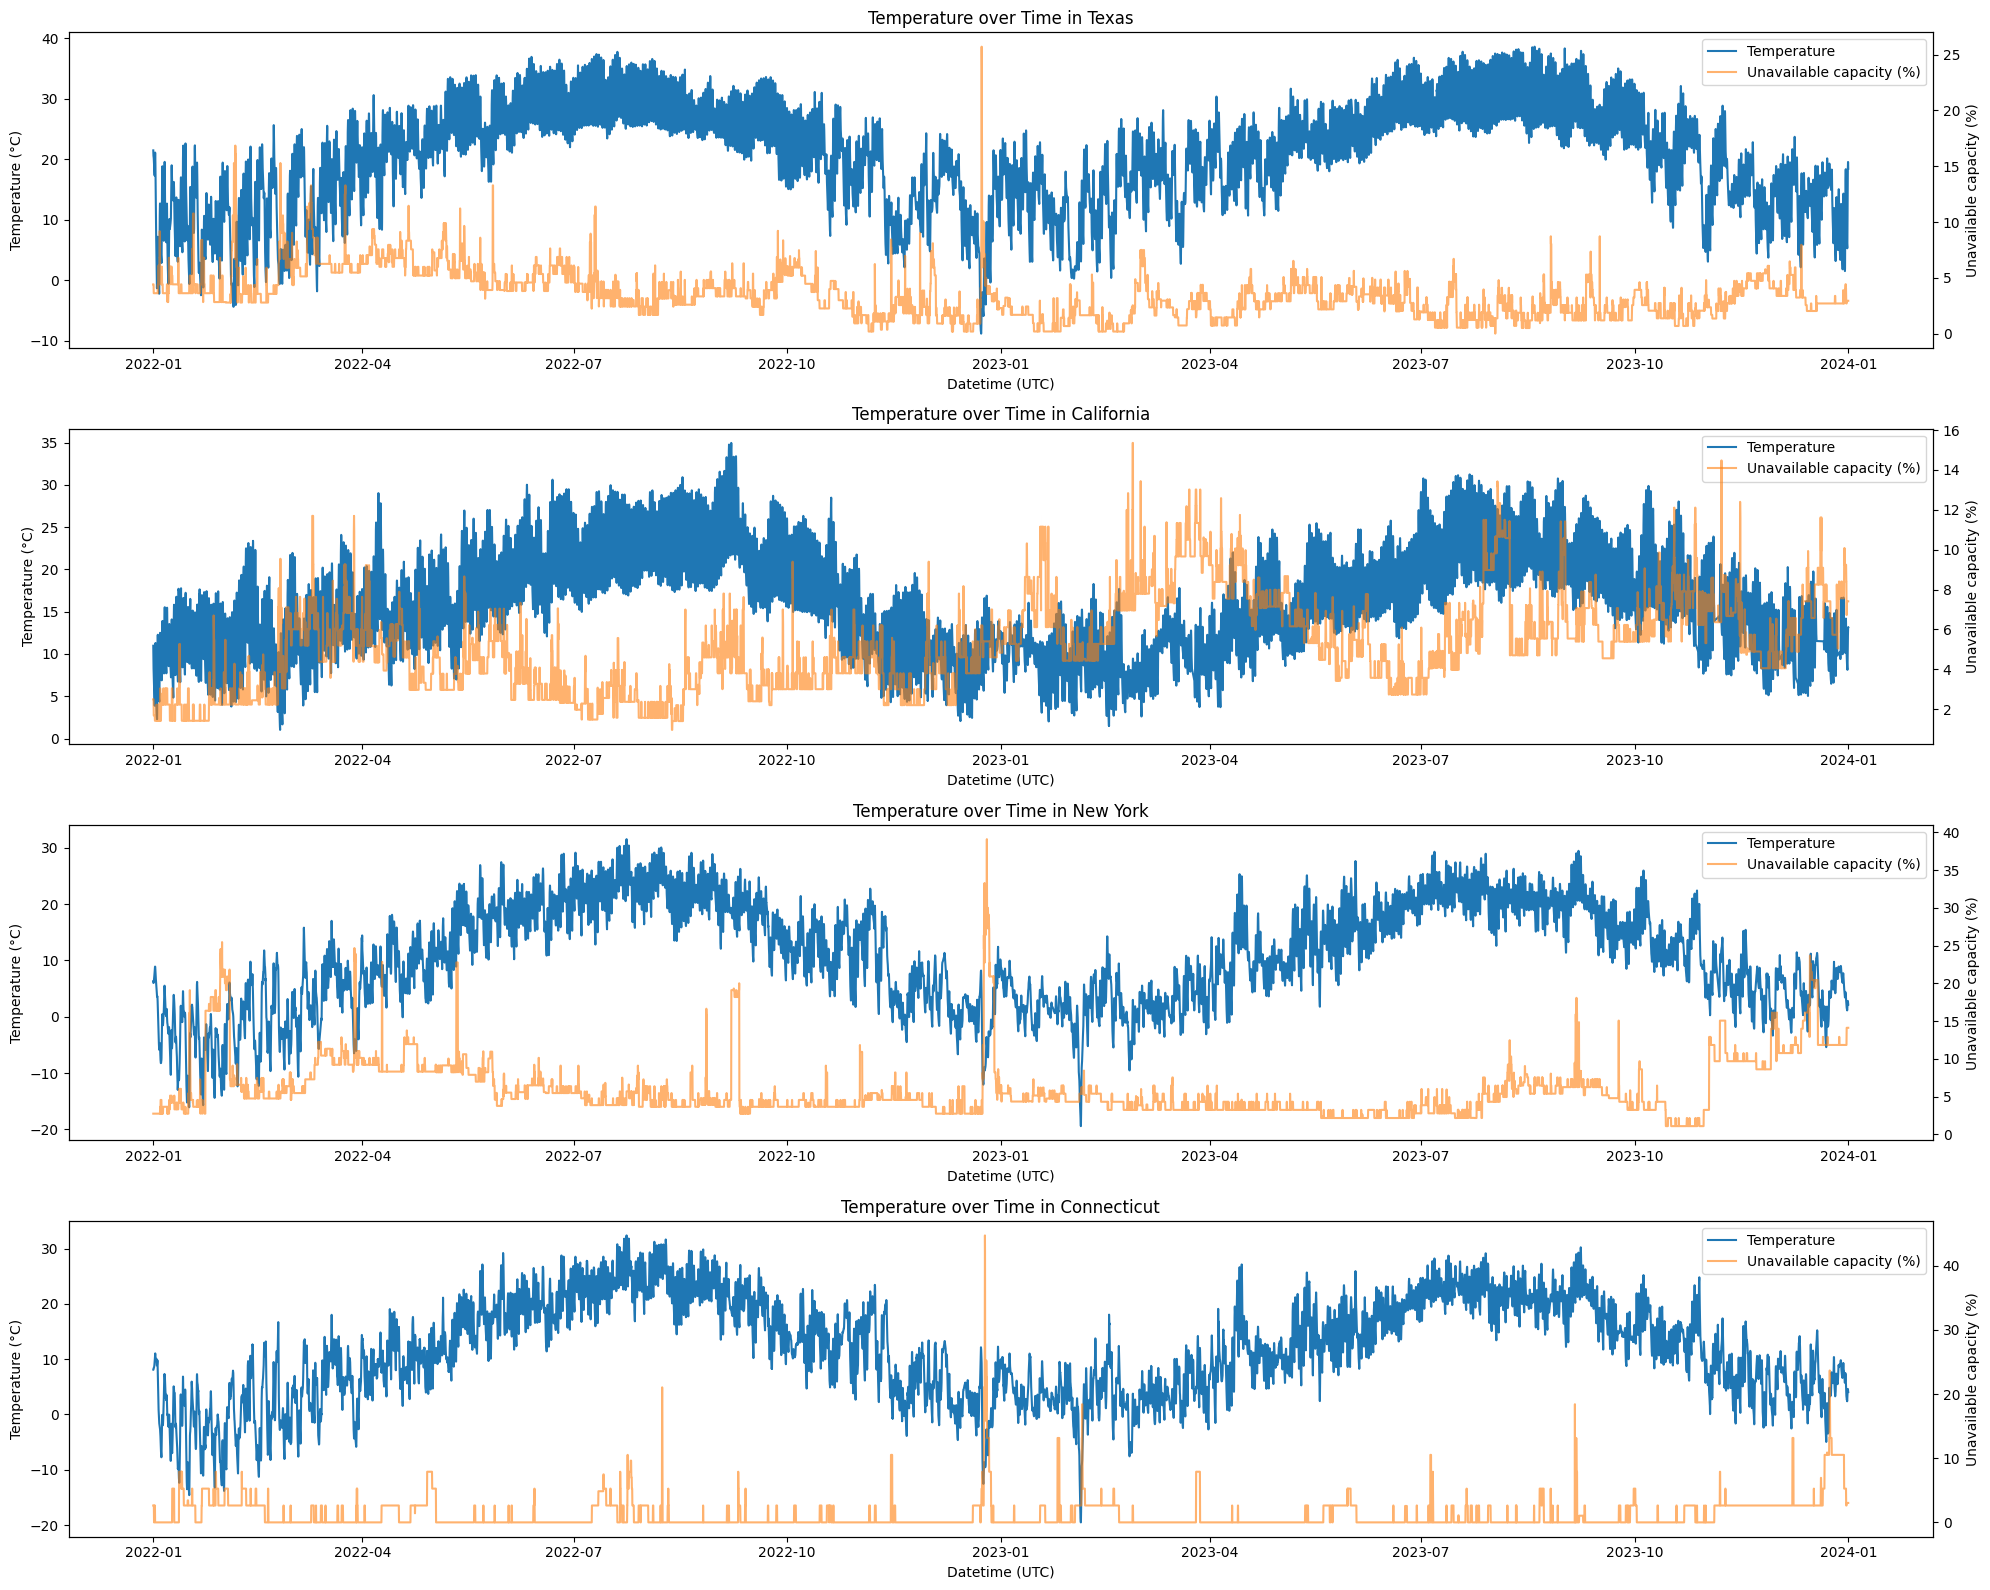

In [10]:
states_to_plot = ['Texas', 'California', 'New York', 'Connecticut'] # 'Massachusetts', 'Pennsylvania'

fig, axs = plt.subplots(len(states_to_plot), 1, figsize=(20,4*len(states_to_plot)))

for i, state in enumerate(states_to_plot):
    inputs_df = scenarios_inputs_by_state[state]
    ax = axs[i]
    dt = inputs_df['Datetime_UTC'].to_numpy(dtype='datetime64[ns]')
    temp = inputs_df['Temperature'].to_numpy()*10

    historical_scenario_df = historical_scenario_by_state[state]
    historical_unavailable_capacity = historical_scenario_df['Unavailable_capacity (%)'].to_numpy()
    historical_dt = historical_scenario_df['Datetime_UTC'].to_numpy(dtype='datetime64[ns]')

    ax.plot(dt, temp, color='tab:blue', label='Temperature')
    ax2 = ax.twinx()
    ax2.plot(historical_dt, historical_unavailable_capacity, color='tab:orange', label='Unavailable capacity (%)', alpha=0.6)

    ax.set_title(f'Temperature over Time in {state}')
    ax.set_xlabel('Datetime (UTC)')
    ax.set_ylabel('Temperature (°C)')
    ax2.set_ylabel('Unavailable capacity (%)')


    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1 + handles2, labels1 + labels2, loc='best')
plt.tight_layout()

# Scenario generation

## Load failure probability models

In [11]:
models_paths = {
    'A': "../Results/Models/MLP_model_thermal_A.pth",
    'D': "../Results/Models/MLP_model_thermal_D.pth",
    'U': "../Results/Models/MLP_model_thermal_U.pth"
}

models = {}
for initial_state in ['A', 'D', 'U']:
    path = models_paths[initial_state]
    ml_model = path.split('/')[-1].split('_')[0]
    if ml_model == 'XGB':
        loader = im.xgboostModel(verbose=False)
    elif ml_model == 'MLP':
        loader = im.MLP(verbose=False)
    model = loader.load_model(path)
    models[initial_state] = model



models_states = {}
for state in states_to_plot:
    models_states[state] = {}
    for initial_state in ['A', 'D', 'U']:
        path = f"../Results/Models/MLP_model_{state}_thermal_{initial_state}.pth"
        ml_model = path.split('/')[-1].split('_')[0]
        if ml_model == 'XGB':
            loader = im.xgboostModel(verbose=False)
        elif ml_model == 'MLP':
            loader = im.MLP(verbose=False)
        model = loader.load_model(path)
        models_states[state][initial_state] = model



Sequential(
  (linear_0): Linear(in_features=90, out_features=256, bias=True)
  (activation_0): ReLU()
  (linear_1): Linear(in_features=256, out_features=512, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=512, out_features=256, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=256, out_features=128, bias=True)
  (activation_3): ReLU()
  (linear_4): Linear(in_features=128, out_features=64, bias=True)
  (activation_4): ReLU()
  (linear_out): Linear(in_features=64, out_features=3, bias=True)
)
Input dim: 90 | Output dim: 3 | Trainable params: 327,555
Loaded MLP from ../Results/Models/MLP_model_thermal_A.pth
Rebuilt with build_model(**['feature_cols', 'target_cols', 'num_classes', 'hidden_sizes', 'activations', 'out_act_fn'])
Sequential(
  (linear_0): Linear(in_features=88, out_features=256, bias=True)
  (activation_0): ReLU()
  (linear_1): Linear(in_features=256, out_features=512, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_feature

/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Generate scenarios

In [12]:
def aggregate_scenario(gen_states_df: pd.DataFrame) -> pd.DataFrame:
    """Agregates individaul generators states into a regional unavailable generation capacity scenario.
    Assumes 
    - Each generator has a capacity of 1 unit.
    - Derates level is random uniform between 0 and 1.
    - Derate level is constant during each outage event.
    INPUTS:
    - gen_states_df: DataFrame with columns ['Datetime_UTC', 'Gen_state', 'UnitID']
    OUTPUTS:
    - scenario_df: DataFrame with columns ['Datetime_UTC', 'Unavailable_capacity']
    """
    # Validate input
    assert 'Datetime_UTC' in gen_states_df.columns, "gen_states_df must contain 'Datetime_UTC' column"
    assert 'Gen_state' in gen_states_df.columns, "gen_states_df must contain 'Gen_state' column"
    assert 'UnitID' in gen_states_df.columns, "gen_states_df must contain 'UnitID' column"


    scenario_df = pd.DataFrame()
    scenario_df['Datetime_UTC'] = gen_states_df['Datetime_UTC'].unique()
    scenario_df = scenario_df.sort_values('Datetime_UTC').reset_index(drop=True)
    scenario_df['Unavailable_capacity'] = 0.0
    scenario_df['Num_units'] = 0

    for unitID, unit_df in gen_states_df.groupby('UnitID'):
        if len(unit_df) != unit_df['Datetime_UTC'].nunique():
            raise ValueError(f"Duplicate Datetime_UTC entries found for UnitID {unitID}")
        
        # For each unit, determine derate levels during outages
        unit_df = unit_df.sort_values('Datetime_UTC').reset_index(drop=True)
        unit_df['Derate_level'] = 0.0  # Default derate level is 0 (fully available)

        outage_mask = unit_df['Gen_state'] == 'U'
        unit_df.loc[outage_mask, 'Derate_level'] = 1.0

        derate_mask = unit_df['Gen_state'] == 'D'
        derate_mask_ = np.concatenate([np.array([0]), derate_mask.to_numpy(dtype=int)])
        derate_change_mask = derate_mask_[1:]-derate_mask_[:-1]
        derate_start_idx = np.where(derate_change_mask == 1)[0]
        derate_end_idx = np.where(derate_change_mask == -1)[0]
        derate_start_end_idx = list(zip(derate_start_idx, derate_end_idx))
        
        for derate_start, derate_end in derate_start_end_idx:
            event_mask = (unit_df.index >= derate_start) & (unit_df.index < derate_end)
            derate_level = np.random.uniform(0, 1)
            unit_df.loc[event_mask, 'Derate_level'] = derate_level
        
        # Add unit's unavailable capacity to scenario
        # scenario_df =   scenario_df.merge(unit_df[['Datetime_UTC', 'Derate_level']],
        #                                  on='Datetime_UTC',
        #                                  how='left',
        #                                  suffixes=('', f'_{unitID}'))
        corresponding_dates_mask = scenario_df['Datetime_UTC'].isin(unit_df['Datetime_UTC'])
        scenario_df.loc[corresponding_dates_mask, 'Unavailable_capacity'] += unit_df['Derate_level'].values
        scenario_df.loc[corresponding_dates_mask, 'Num_units'] += 1
    
    scenario_df['Unavailable_capacity (%)'] = (scenario_df['Unavailable_capacity'] / scenario_df['Num_units']) * 100.0

        
    return scenario_df


In [13]:
def get_stationary_distribution(transition_probability_matrix: np.ndarray) -> np.ndarray:
    """Computes the stationary distribution of a Markov chain given its transition probability matrix.
    INPUTS:
    - transition_probability_matrix: 2D numpy array of shape (n_states, n_states)
    OUTPUTS:
    - stationary_distribution: 1D numpy array of shape (n_states,)
    """
    assert transition_probability_matrix.ndim == 2, "Transition probability matrix must be 2D"
    assert transition_probability_matrix.shape[0] == transition_probability_matrix.shape[1], "Transition probability matrix must be square"
    
    n_states = transition_probability_matrix.shape[0]
    A = np.transpose(transition_probability_matrix) - np.eye(n_states)
    A = np.vstack([A, np.ones(n_states)])
    b = np.zeros(n_states + 1)
    b[-1] = 1.0

    A = A.astype(float)
    b = b.astype(float)

    stationary_distribution, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    return stationary_distribution

In [15]:
def generate_unavailable_capacity_scenario(scenarios_per_gen,
                                                   num_scenarios: int = 1
                                            ) -> pd.DataFrame:
    
    print("Combining unit states into scenarios...")
    gen_scenario_combination = itertools.product(*scenarios_per_gen.values())
    scenarios = []
    
    for s_idx in tqdm(range(num_scenarios), total=num_scenarios, desc="Combining unit states into scenarios"):
        per_gen_dfs = []
        for gen_dfs in scenarios_per_gen.values():
            if len(gen_dfs) == 0:
                continue
            gen_df = gen_dfs[np.random.randint(0, len(gen_dfs))]
            per_gen_dfs.append(gen_df)
        gen_states_df = pd.concat(per_gen_dfs, ignore_index=True)
        scenario_df = aggregate_scenario(gen_states_df)
        scenarios.append(scenario_df)

    return scenarios

#### speed up scenario generation

In [29]:
state = 'Texas'

covariates_inputs_df = scenarios_inputs_by_state[state]
generators_data_df = generators_per_state[state]
generators_data_df = generators_data_df.loc[generators_data_df['Technology'].isin(technologies)].copy()

In [69]:
importlib.reload(sg)

<module 'scenario_generation' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/scenario_generation.py'>

In [70]:
scenarios_per_gen = sg.generate_unavailable_capacity_scenario_per_gen(covariates_inputs_df,
                                                                        generators_data_df,
                                                                        models_states[state],
                                                                        num_scenarios=1000,
                                                                        min_scenarios_per_gen=10
                                                                        )

/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Generating unit states: 100%|██████████| 155/155 [00:19<00:00,  7.79it/s]


In [82]:
importlib.reload(sg)

<module 'scenario_generation' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/scenario_generation.py'>

In [83]:
generated_scenarios = sg.generate_unavailable_capacity_scenario(scenarios_per_gen, 
                                                        num_scenarios=1000
                                                        )

Step 2/3: Selecting per generator scenarios: 100%|██████████| 1000/1000 [00:00<00:00, 4120.02it/s]
Step 3/3: Aggregating unavailable capacity scenarios: 100%|██████████| 1000/1000 [00:08<00:00, 120.18it/s]


### end

In [84]:
generated_scenarios_by_state = {}

for state in states_to_plot:
    print(f"Generating scenarios for state: {state}")

    covariates_inputs_df = scenarios_inputs_by_state[state]
    generators_data_df = generators_per_state[state]
    generators_data_df = generators_data_df.loc[generators_data_df['Technology'].isin(technologies)].copy()

    scenarios_per_gen = sg.generate_unavailable_capacity_scenario_per_gen(covariates_inputs_df,
                                                                            generators_data_df,
                                                                            models_states[state],
                                                                            num_scenarios=1000,
                                                                            )
    
    generated_scenarios = sg.generate_unavailable_capacity_scenario(scenarios_per_gen, 
                                                           num_scenarios=1000
                                                           )
    generated_scenarios_by_state[state] = generated_scenarios


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generating scenarios for state: Texas


Step 2/3: Selecting per generator scenarios: 100%|██████████| 1000/1000 [00:00<00:00, 4164.41it/s]
Step 3/3: Aggregating unavailable capacity scenarios: 100%|██████████| 1000/1000 [00:08<00:00, 117.38it/s]
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generating scenarios for state: California


Step 2/3: Selecting per generator scenarios: 100%|██████████| 1000/1000 [00:00<00:00, 5322.71it/s]
Step 3/3: Aggregating unavailable capacity scenarios: 100%|██████████| 1000/1000 [00:07<00:00, 130.17it/s]
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generating scenarios for state: New York


Step 2/3: Selecting per generator scenarios: 100%|██████████| 1000/1000 [00:00<00:00, 6105.41it/s]
Step 3/3: Aggregating unavailable capacity scenarios: 100%|██████████| 1000/1000 [00:06<00:00, 159.43it/s]
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generating scenarios for state: Connecticut


Step 2/3: Selecting per generator scenarios: 100%|██████████| 1000/1000 [00:00<00:00, 20806.01it/s]
Step 3/3: Aggregating unavailable capacity scenarios: 100%|██████████| 1000/1000 [00:03<00:00, 268.24it/s]


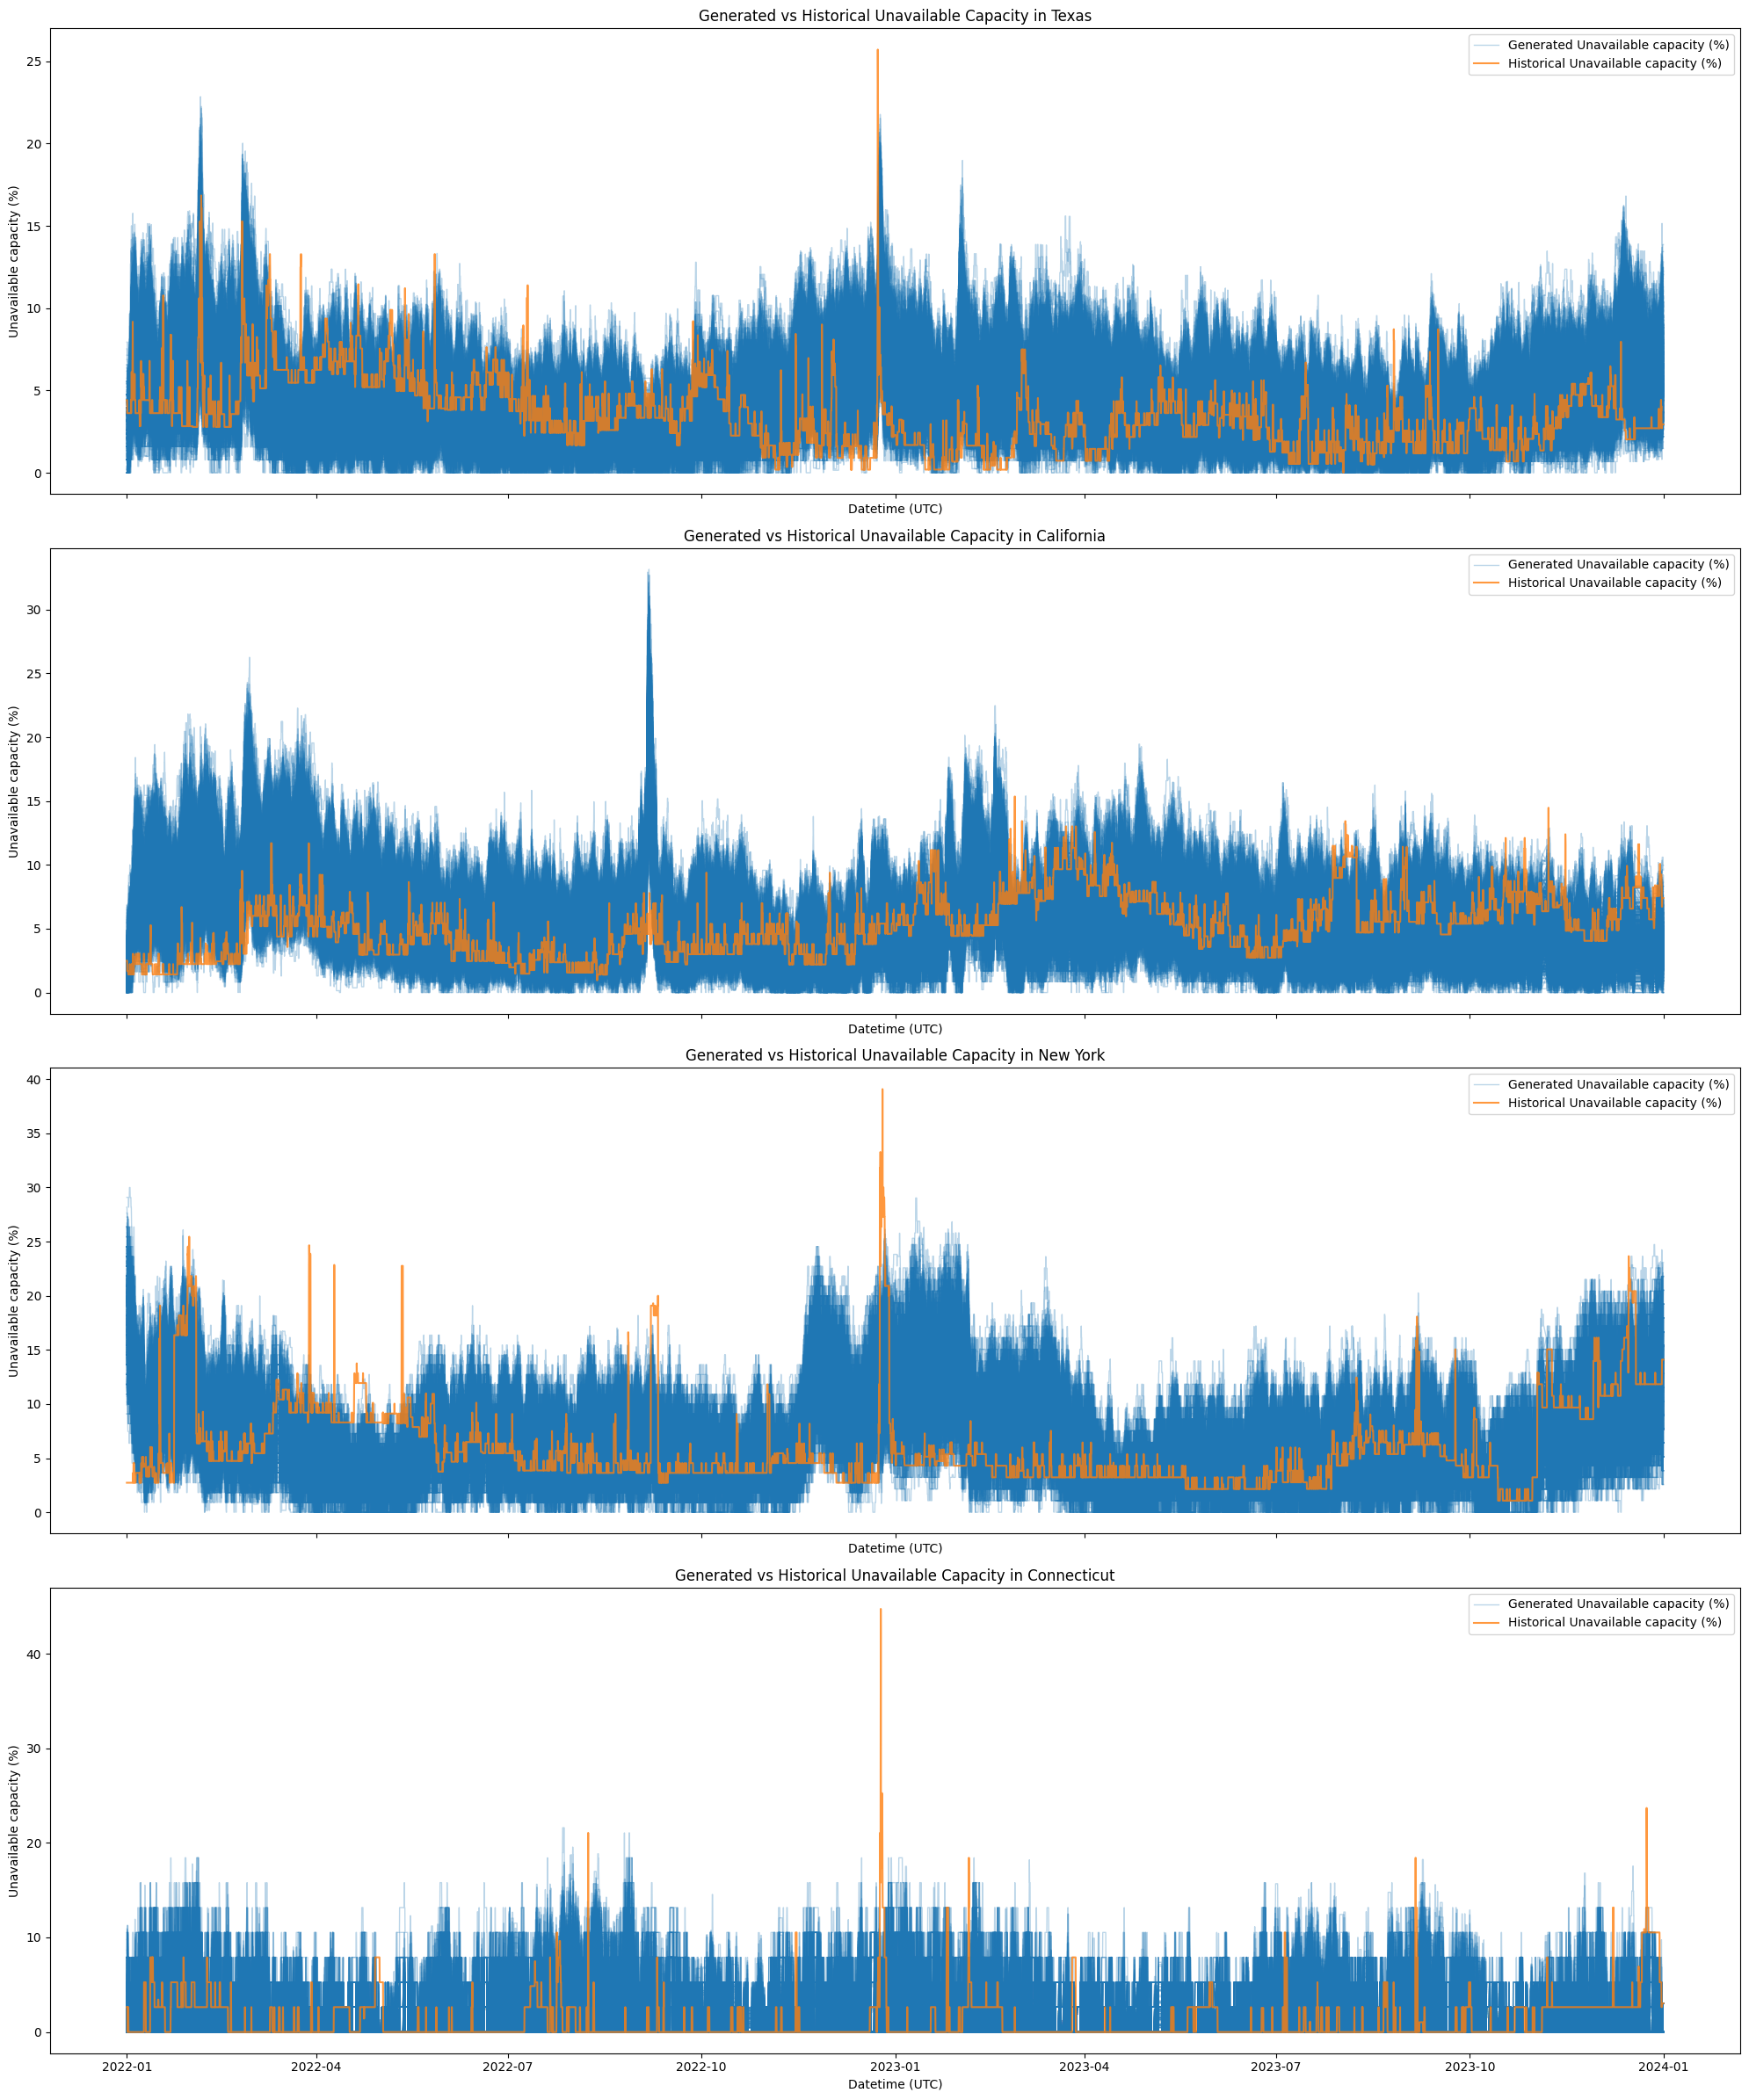

In [85]:
fig, axs = plt.subplots(len(states_to_plot),1, figsize=(20,6*len(states_to_plot)), sharex=True)
for i, state in enumerate(states_to_plot):
    ax = axs[i]
    for i, scenarios in enumerate(generated_scenarios_by_state[state]):
        dt = scenarios['Datetime_UTC'].to_numpy(dtype='datetime64[ns]')
        unavailable_capacity = scenarios['Unavailable_capacity (%)'].to_numpy()
        if i == 0:
            ax.plot(dt, unavailable_capacity, color='tab:blue', linewidth=1, alpha=0.3, label='Generated Unavailable capacity (%)')
        else:
            ax.plot(dt, unavailable_capacity, color='tab:blue', linewidth=1, alpha=0.3)


    historical_scenario_df = historical_scenario_by_state[state]
    historical_unavailable_capacity = historical_scenario_df['Unavailable_capacity (%)'].to_numpy()
    historical_dt = historical_scenario_df['Datetime_UTC'].to_numpy(dtype='datetime64[ns]')
    ax.plot(historical_dt, historical_unavailable_capacity, color='tab:orange', label='Historical Unavailable capacity (%)', alpha=0.8)

    ax.set_title(f'Generated vs Historical Unavailable Capacity in {state}')
    ax.set_xlabel('Datetime (UTC)')
    ax.set_ylabel('Unavailable capacity (%)')
    ax.legend(loc='best')
plt.tight_layout()

# Scenario validation

## Pointwise Validation

### Unconditional marginal

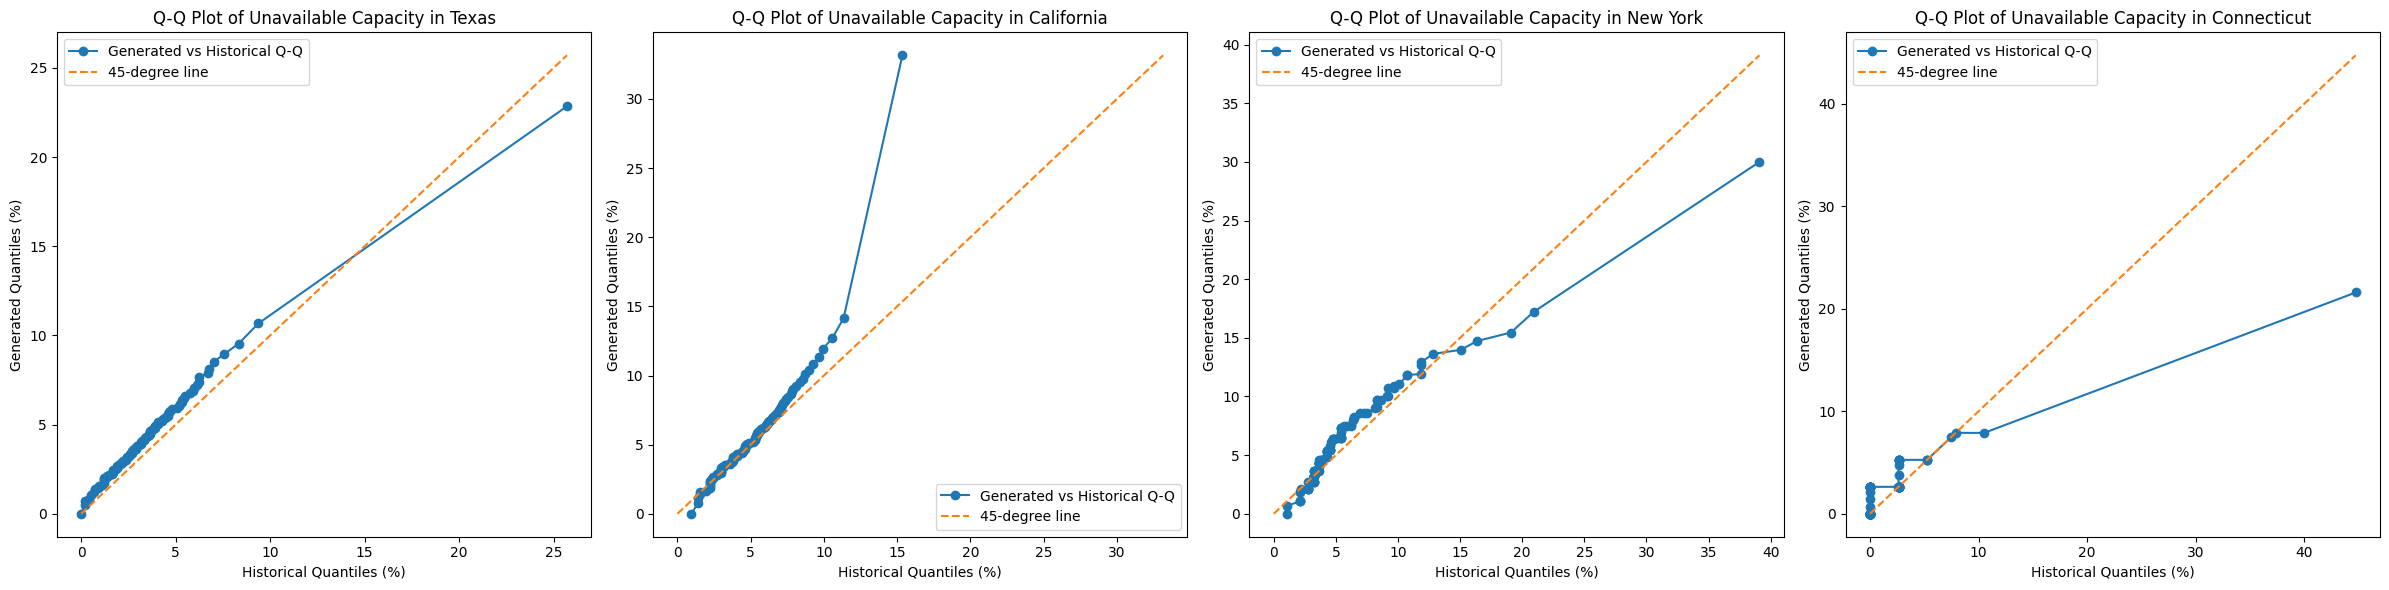

In [86]:
fig, axs = plt.subplots(1, len(states_to_plot), figsize=(6*len(states_to_plot), 6))

for i, state in enumerate(states_to_plot):
    historical_scenario = historical_scenario_by_state[state]
    historical_vals = historical_scenario['Unavailable_capacity (%)'].to_numpy().flatten()
    Q_h = np.quantile(historical_vals, np.linspace(0, 1, 101))

    generated_scenarios = generated_scenarios_by_state[state]
    generated_vals = np.concatenate([scen['Unavailable_capacity (%)'].to_numpy().flatten() for scen in generated_scenarios])
    Q_g = np.quantile(generated_vals, np.linspace(0, 1, 101))
    ax = axs[i]
    ax.plot(Q_h, Q_g, label='Generated vs Historical Q-Q', marker='o', color='tab:blue')
    ax.plot([0, max([Q_h.max(), Q_g.max()])], [0, max([Q_h.max(), Q_g.max()])], linestyle='--', color='tab:orange', label='45-degree line')
    ax.set_title(f'Q-Q Plot of Unavailable Capacity in {state}')
    ax.set_xlabel('Historical Quantiles (%)')
    ax.set_ylabel('Generated Quantiles (%)')
    ax.legend(loc='best')
plt.tight_layout()

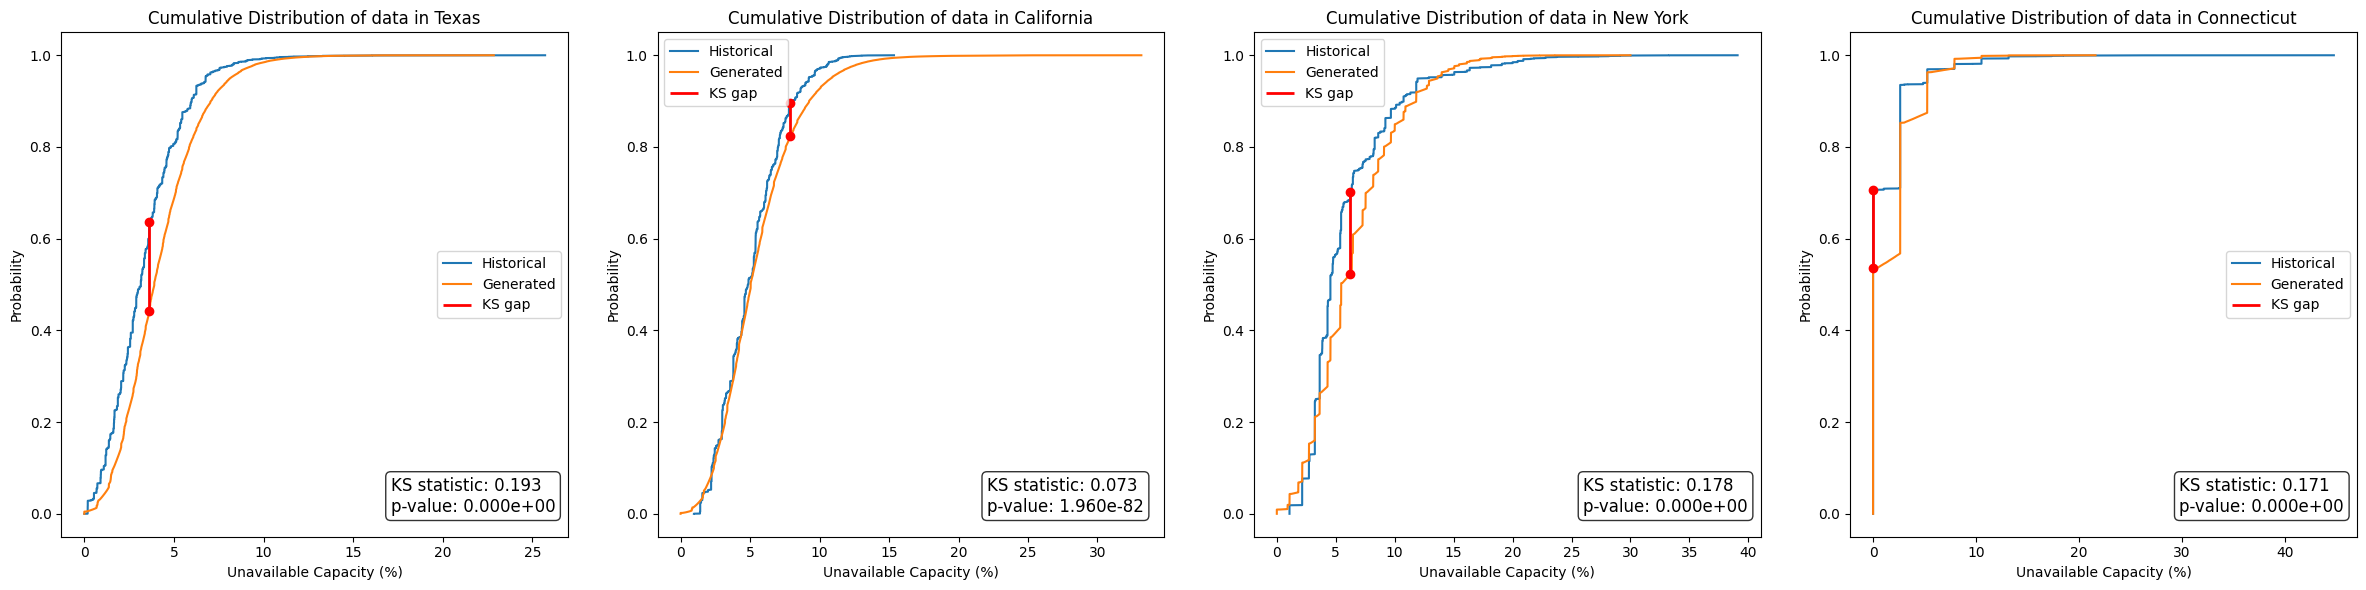

In [87]:
fig, axs = plt.subplots(1, len(states_to_plot), figsize=(6*len(states_to_plot), 6))


for i, state in enumerate(states_to_plot):
    historical_scenario = historical_scenario_by_state[state]
    historical_vals = np.sort(historical_scenario['Unavailable_capacity (%)'].to_numpy().flatten())

    generated_scenarios = generated_scenarios_by_state[state]
    generated_vals = np.sort(np.concatenate([
        scen['Unavailable_capacity (%)'].to_numpy().flatten() 
        for scen in generated_scenarios
    ]))

    # Compute empirical CDFs
    F_hist = np.linspace(0, 1, len(historical_vals))
    F_gen  = np.linspace(0, 1, len(generated_vals))

    # For KS distance, evaluate both samples on a common grid
    combined = np.sort(np.concatenate([historical_vals, generated_vals]))

    # Empirical CDFs evaluated at combined x
    ecdf_hist = np.searchsorted(historical_vals, combined, side="right") / len(historical_vals)
    ecdf_gen  = np.searchsorted(generated_vals,  combined, side="right") / len(generated_vals)

    # KS statistic and location
    diff = np.abs(ecdf_hist - ecdf_gen)
    ks_stat = diff.max()
    x_ks = combined[np.argmax(diff)]

    # Two-sample KS test
    ks_test = ks_2samp(generated_vals, historical_vals)

    # ---------- Plot ----------
    ax = axs[i]
    ax.plot(historical_vals, F_hist, label='Historical', color='tab:blue')
    ax.plot(generated_vals, F_gen,  label='Generated', color='tab:orange')

    # Vertical red bar showing KS gap
    ax.vlines(x_ks, 
              ecdf_gen[np.argmax(diff)], 
              ecdf_hist[np.argmax(diff)], 
              color='red', linewidth=2, label='KS gap')

    # Mark the KS location with a dot
    ax.plot([x_ks], [ecdf_gen[np.argmax(diff)]], 'ro')
    ax.plot([x_ks], [ecdf_hist[np.argmax(diff)]], 'ro')

    # Title and axis labels
    ax.set_title(f'Cumulative Distribution of data in {state}')
    ax.set_xlabel('Unavailable Capacity (%)')
    ax.set_ylabel('Probability')

    # Annotate p-value
    ax.text(0.65, 0.05, 
            f"KS statistic: {ks_stat:.3f}\np-value: {ks_test.pvalue:.3e}",
            transform=ax.transAxes,
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

    ax.legend(loc='best')

plt.tight_layout()
plt.show()

### Conditional marginal

## Chronological Validation

### Temporal persistence

Autocorrelation structure

Persistence of threshold exceedances

### Event-based validation